In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook
import json
import itertools
from scipy.linalg import eig

In [3]:
L = 6  # length of chain
J = 1.0  # strength of the coupling
h = 0.5  # strength of the transverse field
alpha_sym = 1  # hidden unit density for symmetrized RBM
sgd_lr = 0.05  # learning rate of SGD optimizer
n_iter_opt = 250
n_iter_eval = 50

In [4]:
pauli = [np.asarray([[0, 1], [1, 0]]),
         np.asarray([[0, -1j], [1j, 0]]),
         np.asarray([[1, 0], [0, -1]])]
pauliKron = [[np.kron(pauli[i], pauli[j])
              for j in range(3)] for i in range(3)]

# For i!=j, pauli[i]*pauli[j] = permu_sgn[i][j] * 1j * pauli[permu_idx[i][j]]
permu_idx = [[0, 2, 1],
             [2, 1, 0],
             [1, 0, 2]]
permu_sgn = [[0, 1, -1],
             [-1, 0, 1],
             [1, -1, 0]]

pyfile = 'Ising1D_RBMSym'

str_params = '_'.join(['N={}'.format(L),
                       'J={:.1f}'.format(J),
                       'h={:.1f}'.format(h),
                       'a={}'.format(alpha_sym),
                       'lr={:.3f}'.format(sgd_lr)])

def get_idx(l, i):
    return 3 * l + i


def get_mean(psi, sp_op):
    return np.conj(psi) @ sp_op @ psi

In [5]:
data_eval = json.load(open("{}_eval_{}.log".format(pyfile, str_params)))["Output"]
n_obser = len(data_eval[0]) - 2
n_iter_eval == len(data_eval) and n_obser == 3 + L // 2 * 9

True

In [6]:
iters_eval = [it["Iteration"] for it in data_eval]
energy_eval = [it["Energy"]["Mean"] for it in data_eval]
obser_eval = [[it[str(o_idx)]["Mean"] for o_idx in range(n_obser)]
              for it in data_eval]

In [7]:
print("energy = {0:.5f}({1:.5f})\n".format(np.mean(energy_eval),
                                        np.std(energy_eval) / np.sqrt(n_iter_eval)))

energy = -6.38448(0.00014)



In [8]:
def get_VCM(obser_avr):
    obser_avr = np.asarray(obser_avr, dtype=np.complex)
    obser1_avr = obser_avr[0:3]
    obser1_dot_avr = np.asarray([[permu_sgn[i][j] * 1j * obser1_avr[permu_idx[i][j]]
                              if i != j else 1 for j in range(3)] for i in range(3)],
                            dtype=np.complex)
    obser2_avr = obser_avr[3:].reshape([L // 2, 3, 3])
    local1_avr = np.tile(obser1_avr, L)
    local2_avr = np.empty([3 * L, 3 * L], dtype=np.complex)
    for l in range(L):
        local2_avr[3 * l:3 * l + 3, 3 * l:3 * l + 3] = obser1_dot_avr
        for dist in range(1, L // 2 + 1):
            k = (l + dist) % L
            local2_avr[3 * l:3 * l + 3, 3 * k:3 * k + 3] = obser2_avr[dist - 1]
        for dist in range(1, (L - 1) // 2 + 1):
            k = (l + L - dist) % L
            local2_avr[3 * l:3 * l + 3, 3 * k:3 * k +
                       3] = np.transpose(obser2_avr[dist - 1])
    VCM = local2_avr - np.outer(local1_avr, local1_avr)
    return VCM

In [9]:
VCM_eval = [get_VCM(obser) for obser in obser_eval]
emax_eval = [max(np.real(eig(vcm)[0])) for vcm in VCM_eval]

In [10]:
print("emax(VCM) = {0:.5f}({1:.5f})\n".format(np.mean(emax_eval),
                                              np.std(emax_eval) / np.sqrt(n_iter_eval)))

emax(VCM) = 5.65900(0.00790)



In [11]:
npzfile = np.load("save_{}_{}.npz".format(pyfile, str_params))
gs_energy_ed = npzfile["gs_energy_ed"]
gs_psi_ed = npzfile["gs_psi_ed"]
local1_ed = npzfile["local1_ed"]
local2_ed = npzfile["local2_ed"]

In [141]:
gs_energy_ed

array(-6.38469456)

In [12]:
VCM_ed = local2_ed - np.outer(local1_ed, local1_ed)
emax_ed = max(np.real(eig(VCM_ed)[0]))
emax_ed

5.659113047382038

## one-local observables

In [117]:
obser_avr = np.mean(np.asarray(obser_eval, dtype=np.complex), axis=0)
obser1_avr = obser_avr[0:3]

# obs_plt[i,l] = mean of sigma_i(l)
obs_plt = np.real(np.tile(obser1_avr, L).reshape(L, 3).T)
obs_plt_ed = local1_ed.reshape(L, 3).T

In [118]:
obs_plt.max(), obs_plt.min()

(0.26771978575943617, 3.492875703769175e-05)

In [121]:
def matshow_bar3d(ax, data, xlabels, ylabels, zlim):
    xlen, ylen = data.shape
    assert len(xlabels) == xlen and len(ylabels) == ylen

    x, y = np.meshgrid(range(xlen), range(ylen))
    x = x.ravel()
    y = y.ravel()
    z = np.zeros(xlen * ylen) # z coordinates of each bar
    dx = np.ones(xlen * ylen) * 0.8 # length along x-axis of each bar
    dy = np.ones(xlen * ylen) * 0.8 # length along y-axis of each bar
    dz = data.T.ravel() # length along z-axis of each bar (height)

    ax.set_xticks(np.arange(0.5, xlen+0.5, 1))
    ax.set_yticks(np.arange(0.5, ylen+0.5, 1))
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    ax.set_zlim(zlim)
    
    ax.bar3d(x, y, z, dx, dy, dz)

<IPython.core.display.Javascript object>


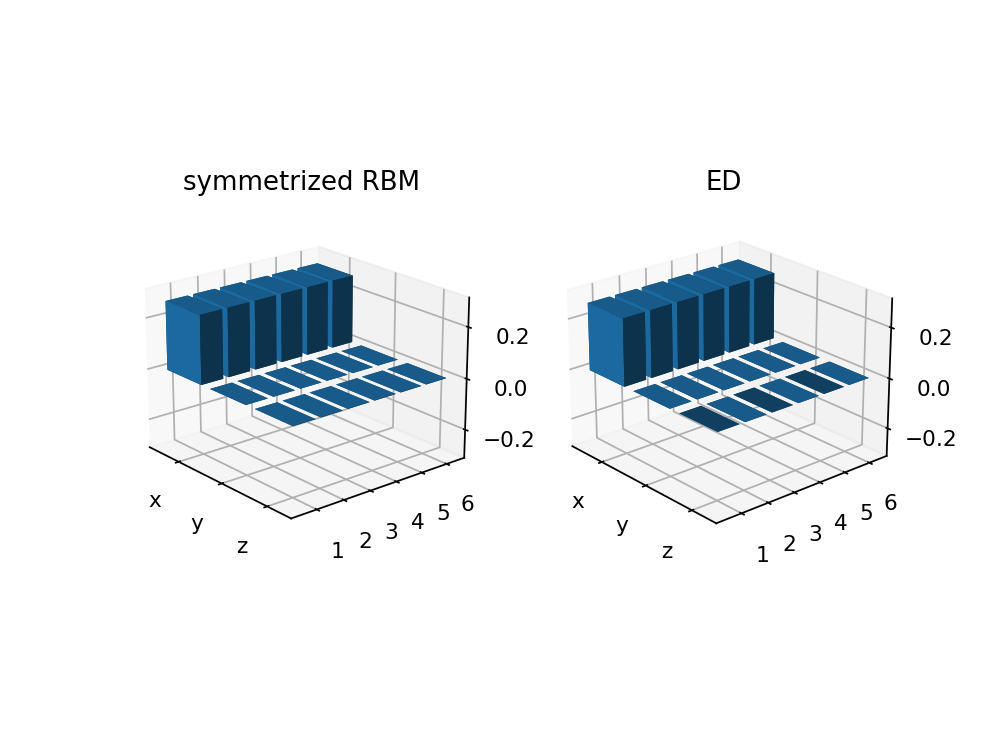

In [124]:
fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
matshow_bar3d(ax1, obs_plt, ["x", "y", "z"], range(1, L+1), [-0.3,0.3])
matshow_bar3d(ax2, obs_plt_ed, ["x", "y", "z"], range(1, L+1), [-0.3,0.3])
ax1.title.set_text('symmetrized RBM')
ax2.title.set_text('ED')
plt.show()

## two-local observables

In [108]:
obser_avr = np.mean(np.asarray(obser_eval, dtype=np.complex), axis=0)
obser1_avr = obser_avr[0:3]
obser1_dot_avr = np.asarray([[permu_sgn[i][j] * 1j * obser1_avr[permu_idx[i][j]]
                          if i != j else 1
                          for j in range(3)] for i in range(3)],
                        dtype=np.complex)
obser2_avr = obser_avr[3:].reshape([L // 2, 3, 3])
# local2_avr[(l,i),(k,j)] = mean of sigma_i(l)*sigma_j(k)
local2_avr = np.empty([3 * L, 3 * L], dtype=np.complex)
for l in range(L):
    local2_avr[3 * l:3 * l + 3, 3 * l:3 * l + 3] = obser1_dot_avr
    for dist in range(1, L // 2 + 1):
        k = (l + dist) % L
        local2_avr[3 * l:3 * l + 3,
                   3 * k:3 * k + 3] = obser2_avr[dist - 1]
    for dist in range(1, (L - 1) // 2 + 1):
        k = (l + L - dist) % L
        local2_avr[3 * l:3 * l + 3,
                   3 * k:3 * k + 3] = np.transpose(obser2_avr[dist - 1])
# obs_xx_plt[l,k] = mean of sigma_x(l)*sigma_x(k)
obs_xx_plt = np.asarray([[local2_avr[3*l+0, 3*k+0] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_xx_plt = np.real(obs_xx_plt)
obs_xx_plt_ed = np.asarray([[local2_ed[3*l+0, 3*k+0] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_xx_plt_ed = np.real(obs_xx_plt_ed)

# obs_yy_plt[l,k] = mean of sigma_y(l)*sigma_y(k)
obs_yy_plt = np.asarray([[local2_avr[3*l+1, 3*k+1] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_yy_plt = np.real(obs_yy_plt)
obs_yy_plt_ed = np.asarray([[local2_ed[3*l+1, 3*k+1] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_yy_plt_ed = np.real(obs_yy_plt_ed)

# obs_zz_plt[l,k] = mean of sigma_z(l)*sigma_z(k)
obs_zz_plt = np.asarray([[local2_avr[3*l+2, 3*k+2] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_zz_plt = np.real(obs_zz_plt)
obs_zz_plt_ed = np.asarray([[local2_ed[3*l+2, 3*k+2] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_zz_plt_ed = np.real(obs_zz_plt_ed)

# obs_xy_plt[l,k] = mean of sigma_x(l)*sigma_y(k)
obs_xy_plt = np.asarray([[local2_avr[3*l+0, 3*k+1] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_xy_plt = np.real(obs_xy_plt)
obs_xy_plt_ed = np.asarray([[local2_ed[3*l+0, 3*k+1] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_xy_plt_ed = np.real(obs_xy_plt_ed)

# obs_yz_plt[l,k] = mean of sigma_y(l)*sigma_z(k)
obs_yz_plt = np.asarray([[local2_avr[3*l+1, 3*k+2] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_yz_plt = np.real(obs_yz_plt)
obs_yz_plt_ed = np.asarray([[local2_ed[3*l+1, 3*k+2] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_yz_plt_ed = np.real(obs_yz_plt_ed)

# obs_xz_plt[l,k] = mean of sigma_x(l)*sigma_z(k)
obs_xz_plt = np.asarray([[local2_avr[3*l+0, 3*k+2] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_xz_plt = np.real(obs_xz_plt)
obs_xz_plt_ed = np.asarray([[local2_ed[3*l+0, 3*k+2] if k != l else 0
            for k in range(L)] for l in range(L)], dtype=np.complex)
obs_xz_plt_ed = np.real(obs_xz_plt_ed)

In [94]:
obs_xx_plt.max(), obs_xx_plt.min()

(0.12027696293610987, 0.0)

In [95]:
obs_yy_plt.max(), obs_yy_plt.min()

(0.052962352707436794, -0.0027171850015856942)

In [99]:
obs_zz_plt.max(), obs_zz_plt.min()

(0.9266666666666664, -0.9304761904761903)

In [113]:
obs_xy_plt_ed.max(), obs_xy_plt_ed.min()

(0.0, 0.0)

In [112]:
obs_yz_plt_ed.max(), obs_yz_plt_ed.min()

(0.0, 0.0)

In [114]:
obs_xz_plt_ed.max(), obs_xz_plt_ed.min()

(2.721434189112415e-14, -2.7283730830163222e-14)

In [115]:
obs_xz_plt.max(), obs_xz_plt.min()

(0.011528351459604451, -0.013763003561434466)

In [84]:
def matshow_2d(ax, data, xlabels, ylabels, zlim):
    norm = mcolors.TwoSlopeNorm(vmin=zlim[0], vmax=zlim[1], vcenter=0)
    ms = ax.matshow(data, cmap=plt.cm.RdBu, norm=norm)
    ax.set_xticks(np.arange(0, L, 1))
    ax.set_yticks(np.arange(0, L, 1))
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    ax.set_xticks(np.arange(-.5, L, 1), minor=True)
    ax.set_yticks(np.arange(-.5, L, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    return ms

<IPython.core.display.Javascript object>


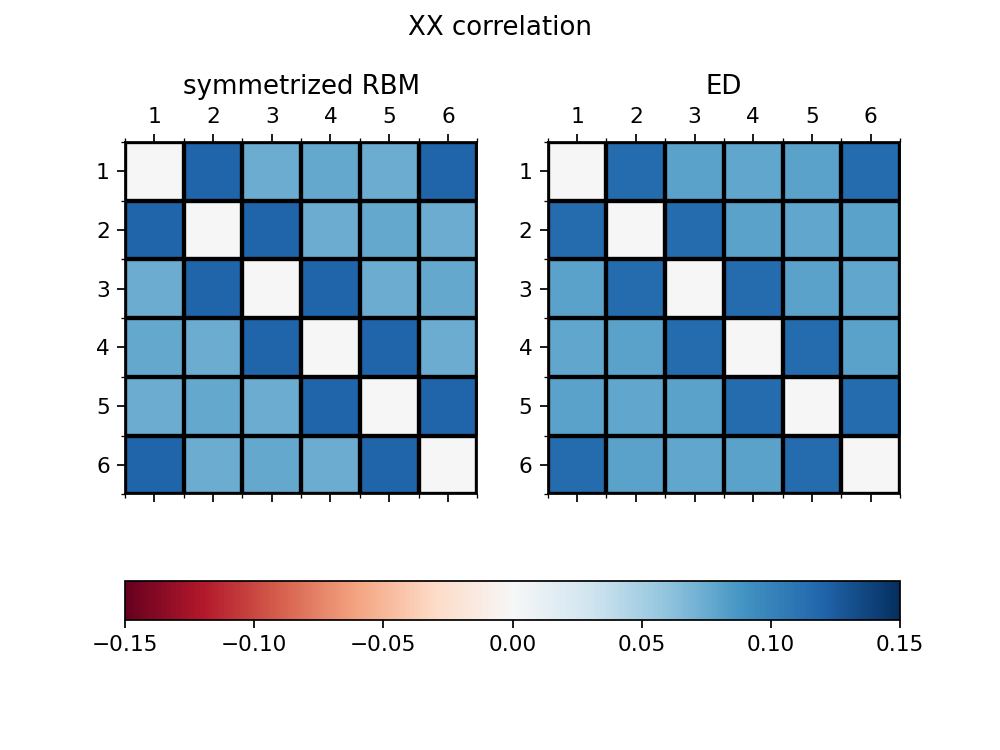

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2)
matshow_2d(axes[0], obs_xx_plt, range(1, L+1), range(1, L+1), [-0.15,0.15])
ms = matshow_2d(axes[1], obs_xx_plt_ed, range(1, L+1), range(1, L+1), [-0.15,0.15])
axes[0].title.set_text('symmetrized RBM')
axes[1].title.set_text('ED')
fig.colorbar(ms, ax=axes.ravel().tolist(), orientation='horizontal')
fig.suptitle('XX correlation')
plt.show()

<IPython.core.display.Javascript object>


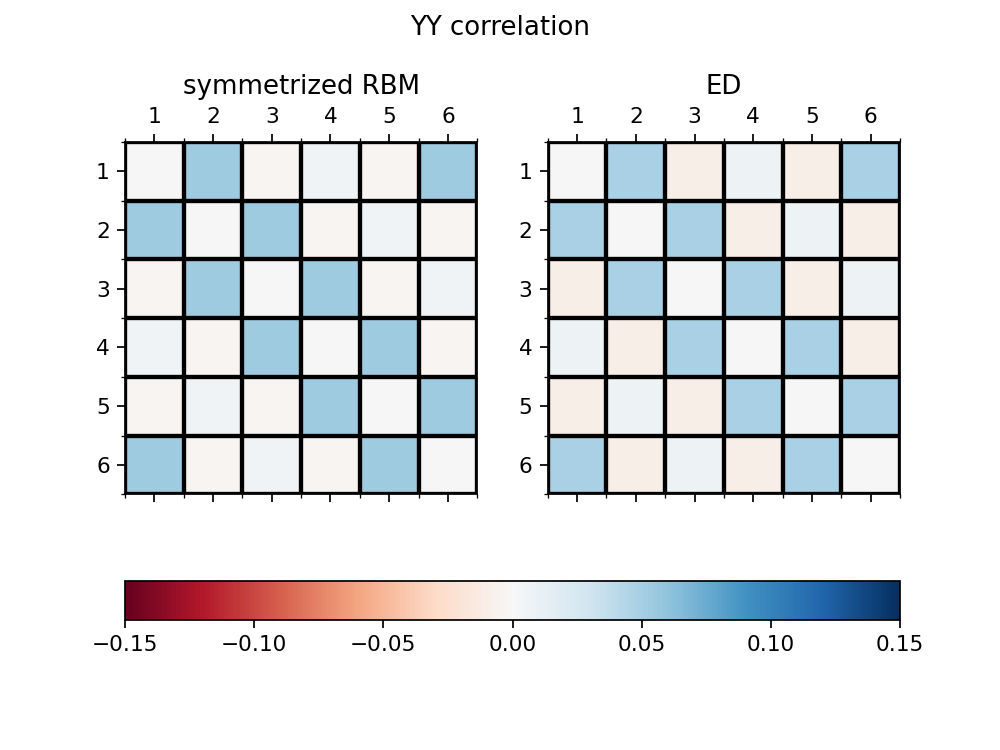

In [116]:
fig, axes = plt.subplots(nrows=1, ncols=2)
matshow_2d(axes[0], obs_yy_plt, range(1, L+1), range(1, L+1), [-0.15,0.15])
ms = matshow_2d(axes[1], obs_yy_plt_ed, range(1, L+1), range(1, L+1), [-0.15,0.15])
axes[0].title.set_text('symmetrized RBM')
axes[1].title.set_text('ED')
fig.colorbar(ms, ax=axes.ravel().tolist(), orientation='horizontal')
fig.suptitle('YY correlation')
plt.show()

<IPython.core.display.Javascript object>


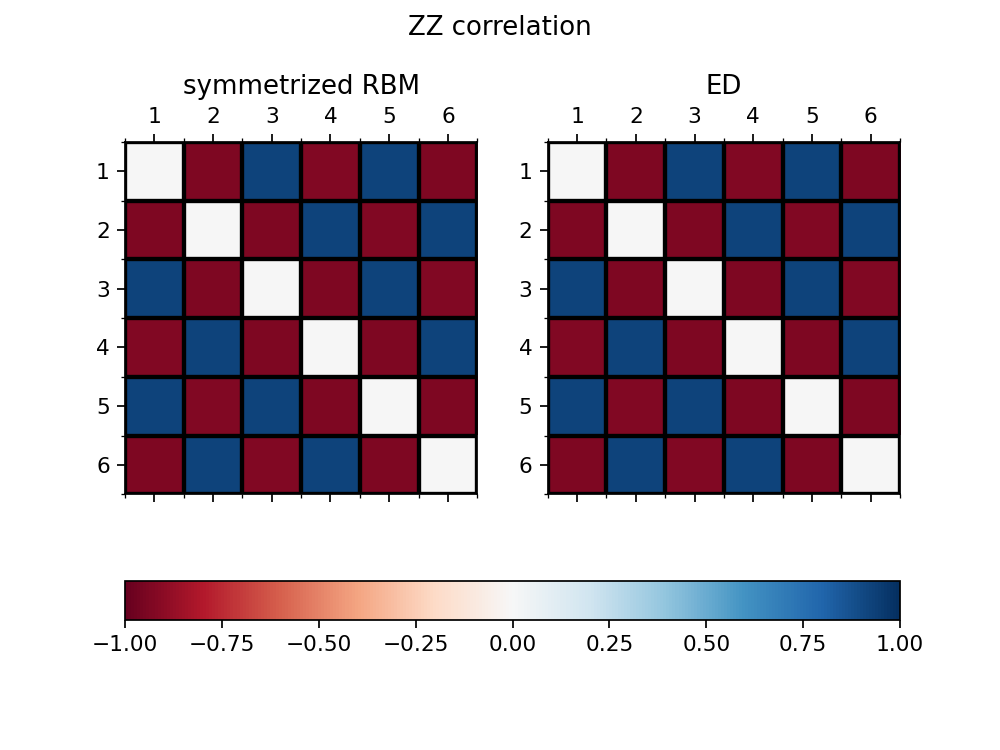

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2)
matshow_2d(axes[0], obs_zz_plt, range(1, L+1), range(1, L+1), [-1,1])
ms = matshow_2d(axes[1], obs_zz_plt_ed, range(1, L+1), range(1, L+1), [-1,1])
axes[0].title.set_text('symmetrized RBM')
axes[1].title.set_text('ED')
fig.colorbar(ms, ax=axes.ravel().tolist(), orientation='horizontal')
fig.suptitle('ZZ correlation')
plt.show()

## VCM

In [125]:
VCM_avr = np.mean(np.asarray(VCM_eval, dtype=np.complex), axis=0)

In [132]:
np.real(VCM_avr).max(), np.real(VCM_avr).min()

(0.9999999829500595, -0.9747572593852354)

In [139]:
np.imag(VCM_avr).max(), np.imag(VCM_avr).min()

(0.26771978575943617, -0.26771978575943617)

In [130]:
def matshow_2d(ax, data, xlabels, ylabels, zlim):
    norm = mcolors.TwoSlopeNorm(vmin=zlim[0], vmax=zlim[1], vcenter=0)
    ms = ax.matshow(data, cmap=plt.cm.RdBu, norm=norm)
    ax.set_xticks(np.arange(0, 3*L, 1))
    ax.set_yticks(np.arange(0, 3*L, 1))
    ax.set_xticklabels(xlabels)
    ax.set_yticklabels(ylabels)
    ax.set_xticks(np.arange(-.5, 3*L, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 3*L, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    return ms

<IPython.core.display.Javascript object>


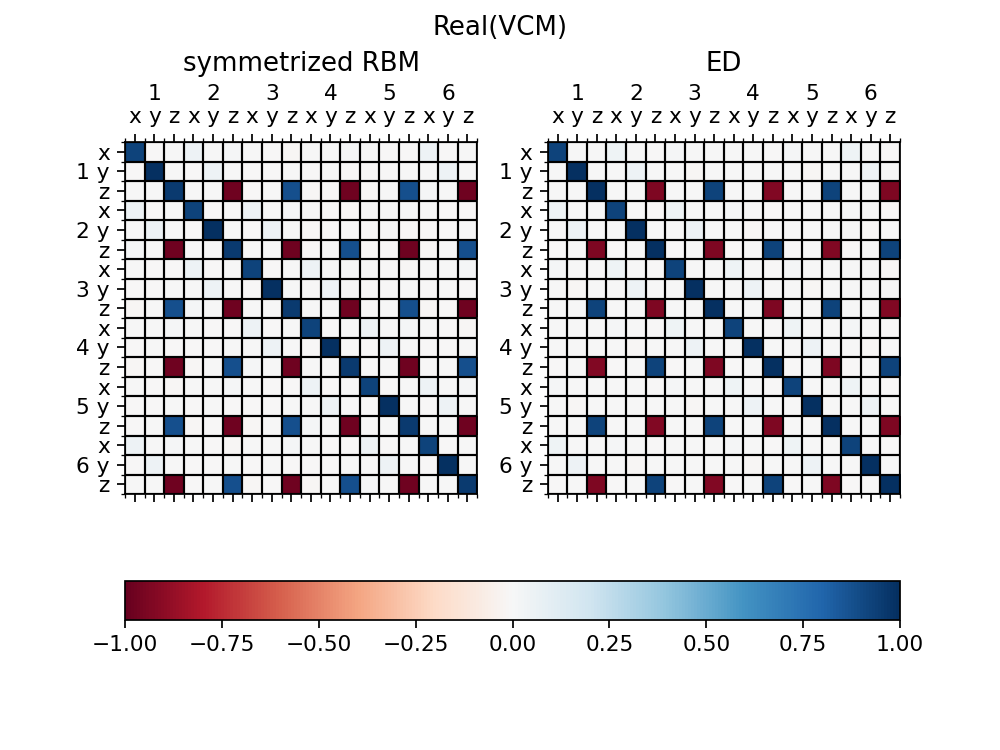

In [138]:
xyzstr = "xyz"
xlabels = ["{}\n{}".format(str(i // 3 + 1), xyzstr[i%3]) if i % 3 == 1 else
           "{}".format(xyzstr[i%3])
           for i in range(3*L)]
ylabels = ["{} {}".format(str(i // 3 + 1), xyzstr[i%3]) if i % 3 == 1 else
           "{}".format(xyzstr[i%3])
           for i in range(3*L)]

fig, axes = plt.subplots(nrows=1, ncols=2)
matshow_2d(axes[0], np.real(VCM_avr), xlabels, ylabels, [-1,1])
ms = matshow_2d(axes[1], np.real(VCM_ed), xlabels, ylabels, [-1,1])
axes[0].title.set_text('symmetrized RBM')
axes[1].title.set_text('ED')
fig.colorbar(ms, ax=axes.ravel().tolist(), orientation='horizontal')
fig.suptitle('Real(VCM)')
plt.show()

<IPython.core.display.Javascript object>


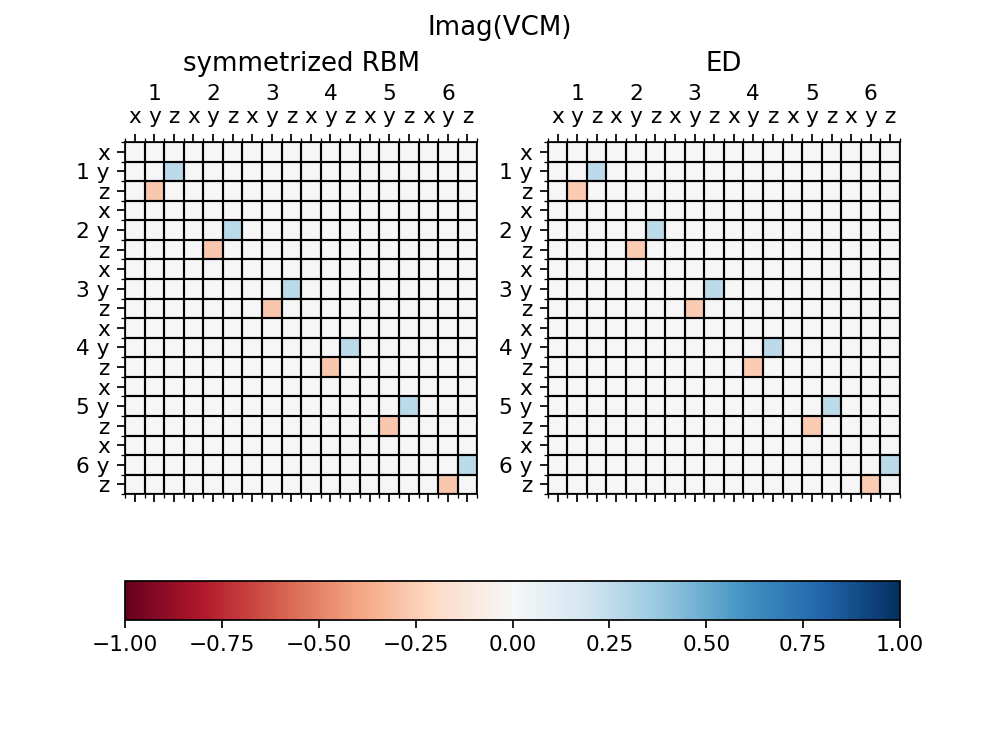

In [140]:
xyzstr = "xyz"
xlabels = ["{}\n{}".format(str(i // 3 + 1), xyzstr[i%3]) if i % 3 == 1 else
           "{}".format(xyzstr[i%3])
           for i in range(3*L)]
ylabels = ["{} {}".format(str(i // 3 + 1), xyzstr[i%3]) if i % 3 == 1 else
           "{}".format(xyzstr[i%3])
           for i in range(3*L)]

fig, axes = plt.subplots(nrows=1, ncols=2)
matshow_2d(axes[0], np.imag(VCM_avr), xlabels, ylabels, [-1,1])
ms = matshow_2d(axes[1], np.imag(VCM_ed), xlabels, ylabels, [-1,1])
axes[0].title.set_text('symmetrized RBM')
axes[1].title.set_text('ED')
fig.colorbar(ms, ax=axes.ravel().tolist(), orientation='horizontal')
fig.suptitle('Imag(VCM)')
plt.show()